# An AI based Image Retrieval System
In this project we will build an information retrieval system. We have a query image and we want to retrieve the most visually similar image for a given dataset. The main idea is to extract relevant vectorial features from images in order to measure a meaningfull similarity distance. 

In this notebook I will apply different pipelines of image retrieval techniques and find the best one. 

## SmallHolidays dataset
The Holidays dataset is a public set of images which mainly contains some personal holidays photos. The dataset contains 1491 images in total : 500 queries and 991 corresponding relevant images. Download the data at http://pascal.inrialpes.fr/data/holidays/copydays_original.tar.gz

## Import Libraries

In [0]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from cv2 import resize, INTER_AREA
import random
from skimage.feature import greycomatrix, greycoprops
from skimage import data
from sklearn.feature_extraction.image import extract_patches_2d
import sklearn.cluster
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_distances
from tqdm import tqdm
import scipy
import h5py
from google.colab import drive
from keras import applications
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
import pickle
from sklearn.cluster import KMeans
import numpy as np
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd drive/My\ \Drive/Colab\ \Notebooks/ImgRet/TP/

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/ImgRet/TP/'
/content/drive/My Drive/Colab Notebooks/ImgRet/TP


# 1) Pipeline based on Pixel Intensity
Here we use the pixels value to compute a similarity measure, we'll see that this method is very limited

In [0]:
# Utils
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def euclidean_dist(im1,im2):
    return np.linalg.norm(im1-im2)

def cosine_dist(im1,im2):
    return scipy.spatial.distance.cosine(im1, im2)

def calculate_distance(query, img_vector):
    diff = (query - np.array(img_vector))
    return float(diff.T @ diff)

We apply dimension reduction of the image using INTER_AREA interpolation, then we flatten the 16x16x3 matrix as a vector. The idea is to downsample the image and get some mean color pixels value which are less specific and permit to select globally similar images.

In [0]:
data = np.load('image_dataset.npz',allow_pickle=True)
X=data['X']
all_keys=np.array(pickle.load(open( "all_keys.p", "rb" )))

X_processed=[]
for k in range(0,X.shape[0]) :  
  img=resize(X[k],(16,16),interpolation = INTER_AREA).flatten()
  X_processed.append(img)
X_processed=np.array(X_processed)

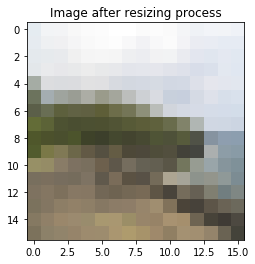

In [0]:
plt.imshow(resize(X[1],(16,16),interpolation = INTER_AREA))
plt.title("Image after resizing process")
plt.show()

In [0]:
query_keys=[]
for line in open("holidays_images.dat","r"): 
    imname=line.strip() 
    imno=int(imname[:-len(".jpg")])
    if imno%100==0:
        query_keys.append(imno)

query_keys=np.array(query_keys)
processed_image_dict = dict(zip(all_keys, X_processed))
base = dict(zip(all_keys, X))

In [0]:
index=query_keys[random.randrange(len(query_keys))]
nb_rank=10
distances=[]
for key in all_keys:
    distances.append(euclidean_dist(processed_image_dict[index],processed_image_dict[key]))

ind_sorted = np.argsort(np.array(distances), axis=0)

all_keys_sorted=all_keys[ind_sorted]
distances_sorted=np.array(distances)[ind_sorted]
ranking=all_keys_sorted[0:nb_rank]
print('Example with index image : ',index)
print('ranking images : ',ranking)
print('ranking scores : ',distances_sorted[0:nb_rank])

relevant_indexes=[index]
for ind in all_keys:
    if ind>index and ind-index<10:
        relevant_indexes.append(ind)
print('relevant indexes : ',relevant_indexes)

num=0
for ind_rank in ranking :
    if ind_rank in relevant_indexes :
        num+=1
        
recall=num/len(relevant_indexes)
precision=num/len(ranking)
print('Precision : ',precision)
print('Recall : ',recall)


Example with index image :  106200
ranking images :  [106200 130300 132507 132506 102900 132502 126805 147901 144104 102901]
ranking scores :  [   0.         2841.49186168 2890.55755867 2910.02542944 2994.63503619
 3017.27144951 3025.24544459 3055.84570946 3058.11739474 3062.25913339]
relevant indexes :  [106200, 106201, 106202]
Precision :  0.1
Recall :  0.3333333333333333


We obsverve that with this pipeline and preprocessing we always get the base image ranked 1st which is good. 

## Implementation for the whole 500 images dataset

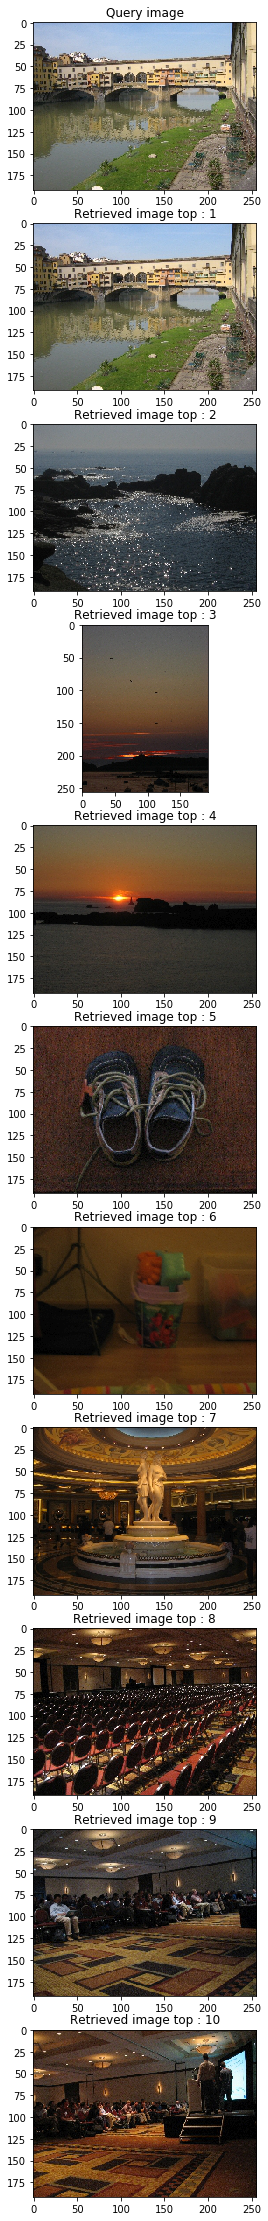

In [0]:
def compute_ranking(processed_image_dict,dist_function,filename, nb_rank=10):
    ranking_dict={}
    relevant_indexes_dict={}
    recall,precision =[],[]
    # Open the file with writing permission
    myfile = open(filename, 'w')
    for index in query_keys:
        distances=[]
        relevant_indexes=[index]
        for key in all_keys:
            distances.append(dist_function(processed_image_dict[index],processed_image_dict[key]))
            if key>index and key-index<100:
                relevant_indexes.append(key)
        ind_sorted = np.argsort(np.array(distances), axis=0)
        all_keys_sorted=all_keys[ind_sorted]
        distances_sorted=np.array(distances)[ind_sorted]
        ranking=all_keys_sorted[0:nb_rank]
        result_line=str(index)+'.jpg 0'
        
        for ind,imagename in enumerate(ranking) :
            if ind+1 != nb_rank:
                result_line += " "+str(imagename)+'.jpg' +" "+ str(ind+1)
            else :
                result_line += " "+str(imagename)+'.jpg'
        
        ranking_relevant_indexes=[np.where(all_keys_sorted  == k)[0][0] for k in relevant_indexes]
        ind=np.argsort(np.array(ranking_relevant_indexes),axis=0)
        relevant_indexes=np.array(relevant_indexes)[ind]

        for ind in relevant_indexes:
            if ind not in ranking:
                result_line +=" "+str(np.where(all_keys_sorted == ind)[0][0])+" "+str(ind)+'.jpg'

        relevant_indexes_dict[index]=relevant_indexes
        # Write a line to the file
        myfile.write(result_line.strip()+'\n')
        ranking_dict[index]=ranking 

    # Close the file
    myfile.close()
    return ranking_dict,relevant_indexes_dict

def display_image(ranking,index):
  n=len(ranking)
  fig, axs = plt.subplots(n+1,figsize=(40, 40))
  axs[0].set_title('Query image')
  axs[0].imshow(base[index]) 
  for i in range(0,n) :
    axs[i+1].imshow(base[ranking[i]])
    axs[i+1].set_title('Retrieved image top : {}'.format(i+1))

                    
ranking_dict,relevant_indexes_dict = compute_ranking(processed_image_dict,euclidean_dist,filename = "ranking_500.dat",nb_rank=10)
index=query_keys[random.randrange(len(query_keys))]
display_image(ranking_dict[index],index)

In [0]:
!python holidays_map.py ranking_500.dat

mAP for ranking_500.dat: 0.02569


With this simple image retrieval system we get :
- 0.002569 for 10 images



# 2) Pipeline based on Haralick Parameters (GLCM) 


(256, 192, 3)

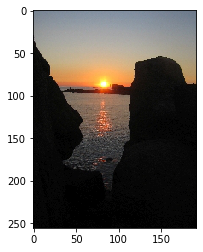

In [0]:
im=X[0]
#im=rgb2gray(im).round().astype('int')
plt.imshow(im)
im.shape

In [0]:
data = np.load('image_dataset.npz',allow_pickle=True)
X=data['X']
all_keys=np.array(pickle.load(open( "all_keys.p", "rb" )))

In [0]:
def compute_Haralick_feature(im):
  im=rgb2gray(im).round().astype('int')
  # Haralick Parameters
  haralick_feature=[]
  for angle in [0,45,90]:
    glcm = greycomatrix(im, distances=[5], angles=[angle], levels=256,
                            symmetric=True, normed=True)
    contrast= greycoprops(glcm,prop='contrast')[0][0]
    dissimilarity= greycoprops(glcm,prop='dissimilarity')[0][0]
    homogeneity= greycoprops(glcm,prop='homogeneity')[0][0]
    energy= greycoprops(glcm,prop='energy')[0][0]
    correlation= greycoprops(glcm,prop='correlation')[0][0]
    haralick_feature.append(contrast)
    haralick_feature.append(dissimilarity)
    haralick_feature.append(homogeneity)
    haralick_feature.append(energy)
    haralick_feature.append(correlation)
  return(np.array(haralick_feature))

features=[]
for img in X : 
  features.append(compute_Haralick_feature(img))

features=np.array(features)

base = dict(zip(all_keys, features))
ranking_dict,relevant_indexes_dict=compute_ranking(base,euclidean_dist,filename = "ranking_GLCM.dat")

In [0]:
!python holidays_map.py ranking_GLCM.dat

mAP for ranking_GLCM.dat: 0.05293


# 3) Pipeline based on BOVW
Bag Of Visual Words is a method taken from NLP which consists in building visual words. A visual word is a patch that describes a part of an image. For example it can be a part of a Bicycle wheel for a Bicycle image.


In [0]:
data = np.load('image_dataset.npz',allow_pickle=True)
X=data['X']
all_keys=np.array(pickle.load(open( "all_keys.p", "rb" )))
query_keys=[]
for line in open("holidays_images.dat","r"): 
    imname=line.strip() 
    imno=int(imname[:-len(".jpg")])
    if imno%100==0:
        query_keys.append(imno)

query_keys=np.array(query_keys)

In [0]:
def preprocess_data(X):
  function = lambda t: np.hstack((t[:,:,0],t[:,:,1],t[:,:,2]))
  vfunc = np.vectorize(function,otypes=[np.ndarray])
  return vfunc(X)
X=preprocess_data(X)

In [0]:
patch_size=16
max_patches=50
n=len(X)
patches=np.zeros([max_patches*n, patch_size, patch_size])
for k,im in tqdm(enumerate(X)) :
    im_patches=extract_patches_2d(im,(patch_size,patch_size),max_patches=max_patches)
    for i,patch in enumerate(im_patches):
      i=i+k*max_patches
      patches[i]=patch

feature=[]
#patch -> description vectorielle
for patch in patches :
    feature.append(patch.flatten())
    # optional feature extraction 
    # on effectue un kmeans entre(500-1000 clusters) sur les patch 
    # le centroide est le mot visuel
feature=np.array(feature)

1491it [00:00, 4786.63it/s]


In [0]:
kmeans = KMeans(n_clusters=500, random_state=0).fit(feature)
#kmeans.labels_
#kmeans.predict()
visual_words=kmeans.cluster_centers_
pickle.dump(kmeans,open("kmeans.p","wb"))
# intersection d'histogrames

In [0]:
def build_histogram(im,n_patches,patch_size=patch_size,max_patches=max_patches):
    patches=extract_patches_2d(im,(patch_size,patch_size),max_patches=max_patches)
    hist=np.zeros([n_patches])
    for patch in patches:
        hist[kmeans.predict([patch.flatten()])[0]]+=1
    return hist

def hist_dist(h1,h2):
    return np.sum(np.minimum(h1,h2))

In [0]:
histograms=[]
for im in tqdm(X) :
    histograms.append(build_histogram(im,len(visual_words)))
base = dict(zip(all_keys, histograms))
ranking_dict,relevant_indexes_dict=compute_ranking(base,hist_dist,filename = "ranking_bovw.dat")

100%|██████████| 1491/1491 [01:04<00:00, 23.24it/s]


In [0]:
!python holidays_map.py ranking_bovw.dat

mAP for ranking_bovw.dat: 0.00124


# 4) Pipeline based on Point Of Interrest 

In [0]:
from skimage.feature import ORB

data = np.load('image_dataset.npz',allow_pickle=True)
X=data['X']
all_keys=np.array(pickle.load(open( "all_keys.p", "rb" )))

In [0]:

X_processed=[]
for k in tqdm(range(0,X.shape[0])) :  
  extractor = ORB(n_keypoints=100)
  extractor.detect_and_extract(rgb2gray(X[k]))
  descriptors = np.array(extractor.descriptors, dtype='float32')
  X_processed.append(descriptors)

X_processed=np.array(X_processed)

100%|██████████| 1491/1491 [04:51<00:00,  4.96it/s]


In [0]:
features = np.concatenate(X_processed, axis=0)
kmeans = KMeans(n_clusters=500, random_state=0).fit(features)
#kmeans.labels_
#kmeans.predict()
pickle.dump(kmeans,open("kmeans_ORB.p","wb"))
# intersection d'histogrames

In [0]:
visual_words.shape

(500, 256)

In [0]:
kmeans=pickle.load( open( "kmeans_ORB.p", "rb" ) )
visual_words=kmeans.cluster_centers_
histograms=[]
for im in tqdm(preprocess_data(X)) :
    histograms.append(build_histogram(im,len(visual_words)))
base = dict(zip(all_keys, histograms))
ranking_dict,relevant_indexes_dict=compute_ranking(base,hist_dist,filename = "ranking_ORB.dat")

100%|██████████| 1491/1491 [01:34<00:00, 15.82it/s]


In [0]:
!python holidays_map.py ranking_ORB.dat

mAP for ranking_ORB.dat: 0.00396


With this  image retrieval system we get :
- 0.00124 for 10 images

It is still a disapointing result

# 5) Pipeline using Deep Learning 


In [0]:
data = np.load('image_dataset.npz',allow_pickle=True)
X=data['X']
all_keys = np.array(pickle.load(open("all_keys.p", "rb")))
query_keys=[]
for line in open("holidays_images.dat","r"): 
    imname=line.strip() 
    imno=int(imname[:-len(".jpg")])
    if imno%100==0:
        query_keys.append(imno)
query_keys=np.array(query_keys)
base = dict(zip(all_keys, X))



#model = applications.resnet50.ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = applications.resnet.ResNet152(weights='imagenet', include_top=False, pooling='avg')

X_processed=[]
for im in tqdm(X):
    x = resize(im, (224, 224), interpolation=INTER_AREA)
    # convert image to numpy array
    #x = image.img_to_array(x)
    # the image is now in an array of shape (3, 224, 224) 
    # need to expand it to (1, 3, 224, 224) as it's expecting a list
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #x = np.transpose(x, (2, 1, 0))
    X_processed.append(x)

X_processed=np.array(X_processed)













234700800/234698864 [==============================] - 6s 0us/step


100%|██████████| 1491/1491 [00:01<00:00, 1398.72it/s]


In [0]:
# extract the features
#features = model.predict(X)
features=[]
for i in tqdm(range(0,X_processed.shape[0])):
  features.append(model.predict(X_processed[i]))
features=np.array(features)
import pickle
pickle.dump(features, open( "features.p", "wb" ) )

100%|██████████| 1491/1491 [01:09<00:00, 21.33it/s]


In [0]:
features = pickle.load( open( "features.p", "rb" ) )
feature_dict = dict(zip(all_keys, features))
ranking_dict,relevant_indexes_dict=compute_ranking(feature_dict,euclidean,filename = "ranking_cnn.dat",nb_rank=10)

In [0]:
!python holidays_map.py ranking_cnn.dat

mAP for ranking_cnn.dat: 0.78087


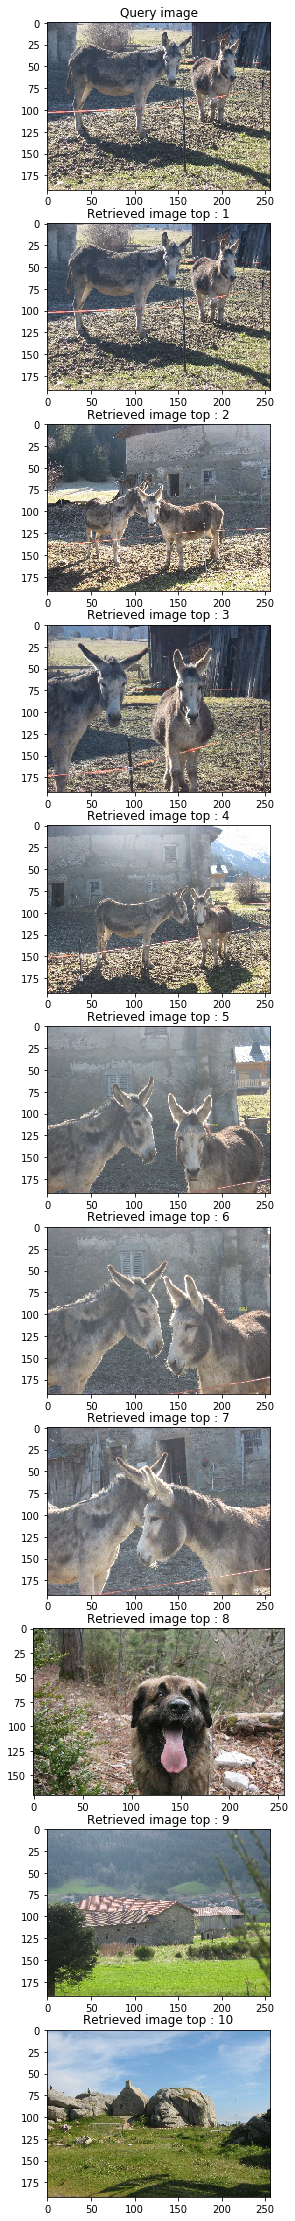

In [0]:
# cet index est un bon exemple 132800
index=query_keys[random.randrange(len(query_keys))]
index=136700 #Anes
#index=123700 #Bateaux
#index=140500 #Eglises
#index=108100 #Sphynx
display_image(ranking_dict[index],index)

# 6) Deep Learning + Haralick Pipeline

In [0]:
# extract the features
#features = model.predict(X)
features=[]
for i in tqdm(range(0,X_processed.shape[0])):
  feature_cnn=model.predict(X_processed[i])
  feature_haralick_parameters=compute_Haralick_feature(X[i])
  feature_haralick_parameters=np.expand_dims(feature_haralick_parameters,axis=0)
  np.concatenate((feature_cnn,feature_haralick_parameters),axis=1)
  features.append(np.concatenate((feature_cnn,feature_haralick_parameters),axis=1))
features=np.array(features)
import pickle
pickle.dump(features, open( "features_hara_cnn.p", "wb" ) )

100%|██████████| 1491/1491 [01:27<00:00, 17.12it/s]


In [0]:
features = pickle.load( open( "features_hara_cnn.p", "rb" ) )
feature_dict = dict(zip(all_keys, features))
ranking_dict,relevant_indexes_dict=compute_ranking(feature_dict,euclidean,filename = "ranking_cnn_hara.dat",nb_rank=10)

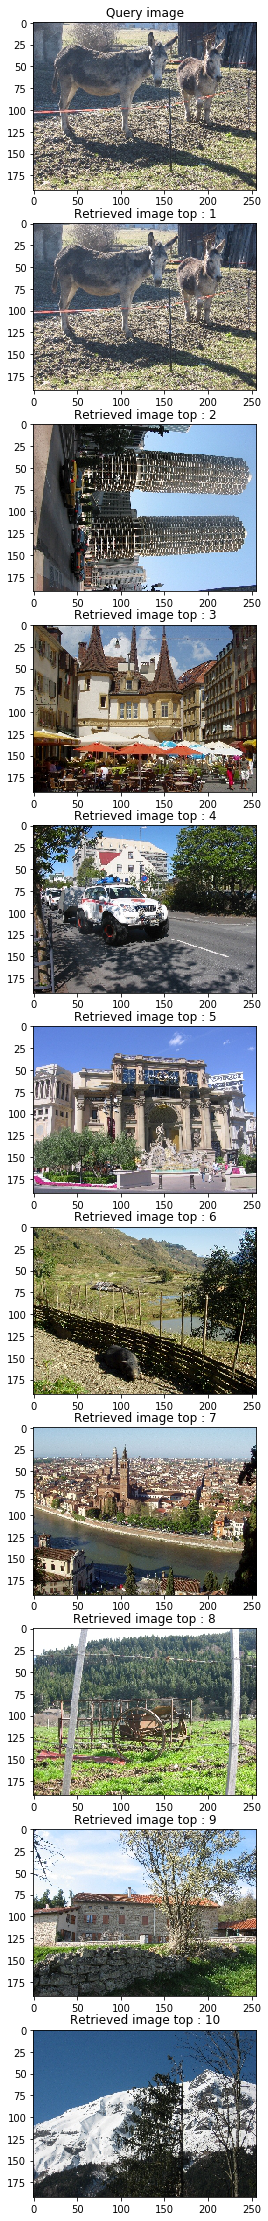

In [0]:
# cet index est un bon exemple 132800
index=query_keys[random.randrange(len(query_keys))]
index=136700 #Anes
#index=123700 #Bateaux
#index=140500 #Eglises
#index=108100 #Sphynx
display_image(ranking_dict[index],index)

In [0]:
!python holidays_map.py ranking_cnn.dat
!python holidays_map.py ranking_cnn_hara.dat
!python holidays_map.py ranking_500.dat
!python holidays_map.py ranking_ORB.dat
!python holidays_map.py ranking_GLCM.dat
!python holidays_map.py ranking_bovw.dat

mAP for ranking_cnn.dat: 0.78087
mAP for ranking_cnn_hara.dat: 0.07193
mAP for ranking_500.dat: 0.02569
mAP for ranking_ORB.dat: 0.00396
mAP for ranking_GLCM.dat: 0.05293
mAP for ranking_bovw.dat: 0.00124


# Conclusion

From the results we obtained upper we can draw the conclusion that deep learning based methods  outperform all other image processing techniques. 


One shot learning consists in learning from one (or a few) examples. It is a concept closely related to image retrieval. If you are interested in siamese networks for image retrieval, you can read these 3 blog posts, which mostly focus about one shot learning:

https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e
https://sorenbouma.github.io/blog/oneshot/
https://towardsdatascience.com/one-shot-learning-face-recognition-using-siamese-neural-network-a13dcf739e